<a href="https://colab.research.google.com/github/jith4j/Tuberculosis-Classification/blob/main/Tuber_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 The Dataset

## 1.1 Kaggle API json token

In [31]:
! pip install -q kaggle
import os
import shutil

# Create a .kaggle folder if it doesn't exist
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

# Copy your kaggle.json into that folder
shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))


'C:\\Users\\divya/.kaggle/kaggle.json'

In [32]:
!python.exe -m pip install --upgrade pip


## 1.2 Download the dataset

By providing the Kaggle Dataset API command.

In [33]:
! kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
tuberculosis-tb-chest-xray-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


## 1.3 Unzipping


In [34]:
import zipfile
import os

# point to the zip file you actually downloaded
zf = "tuberculosis-tb-chest-xray-dataset.zip"

# choose where to extract
target_dir = os.path.join(os.getcwd(), "dataset", "cnn", "tuberculosis_revamped")

# make sure the target folder exists
os.makedirs(target_dir, exist_ok=True)

# extract
with zipfile.ZipFile(zf, 'r') as zfile:
    zfile.extractall(target_dir)

print("✅ Dataset extracted successfully to:", target_dir)


✅ Dataset extracted successfully to: c:\Users\divya\OneDrive\TB_DETECTION\Tuberculosis-Classification-main\dataset\cnn\tuberculosis_revamped


## 1.4 Spliting to Train, Validation, Test

In [35]:
%pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [36]:
import splitfolders
import os

# point to your extracted dataset
input_folder = os.path.join(os.getcwd(), "dataset", "cnn", "tuberculosis_revamped", "TB_Chest_Radiography_Database")

# define output folder
output_folder = os.path.join(os.getcwd(), "dataset", "cnn", "tuberculosis")

# split into train, val, test
splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=1337,
    ratio=(.7, .2, .1),
    group_prefix=None
)

print("✅ Dataset successfully split into train, val, and test sets.")



Copying files: 4200 files [00:03, 1327.69 files/s]

✅ Dataset successfully split into train, val, and test sets.


In [37]:
import shutil
import os

path_to_delete = os.path.join(os.getcwd(), "dataset", "cnn", "tuberculosis_revamped")

# Delete the folder if it exists
if os.path.exists(path_to_delete):
    shutil.rmtree(path_to_delete)
    print("✅ Deleted:", path_to_delete)
else:
    print("⚠️ Folder not found:", path_to_delete)


✅ Deleted: c:\Users\divya\OneDrive\TB_DETECTION\Tuberculosis-Classification-main\dataset\cnn\tuberculosis_revamped


Following code is to make test directory have a single folder with both Normal and Tuberculosis datas.
In our case we do not require this part of the code hence its commented.

In [38]:
# !mv  -v /content/dataset/cnn/tuberculosis/test/Normal/* /content/dataset/cnn/tuberculosis/test/
# !mv  -v /content/dataset/cnn/tuberculosis/test/Tuberculosis/* /content/dataset/cnn/tuberculosis/test/
# !rm -r /content/dataset/cnn/tuberculosis/test/Normal
# !rm -r /content/dataset/cnn/tuberculosis/test/Tuberculosis

# 2 Initialize

## 2.1 Basic Imports

In [39]:
#Some Basic Imports
import matplotlib.pyplot as plt #For Visualization
import numpy as np              #For handling arrays
import pandas as pd             # For handling data

## 2.2 Define Directories

In [40]:
#Define Directories for train, test & Validation Set
train_path = '/content/dataset/cnn/tuberculosis/train'
test_path = '/content/dataset/cnn/tuberculosis/test'
valid_path = '/content/dataset/cnn/tuberculosis/val'

## 2.3 Basic Parameters

In [41]:
#The batch refers to the number of training examples utilized in one #iteration
batch_size = 16 
#The dimension of the images we are going to define is 500x500 img_height = 500
img_height = 500
img_width = 500

# 3 Preparing the Data

## 3.1 Data Augmentation

In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                rescale = 1./255,
                                #shear_range = 0,
                                #zoom_range = 0,
                                horizontal_flip = True,          
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [43]:
train_path = "dataset/cnn/tuberculosis/train"
test_path = "dataset/cnn/tuberculosis/test"
valid_path = "dataset/cnn/tuberculosis/val"


In [44]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, 
      class_mode='binary',
      batch_size=batch_size
      )

valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 2939 images belonging to 2 classes.
Found 421 images belonging to 2 classes.
Found 840 images belonging to 2 classes.


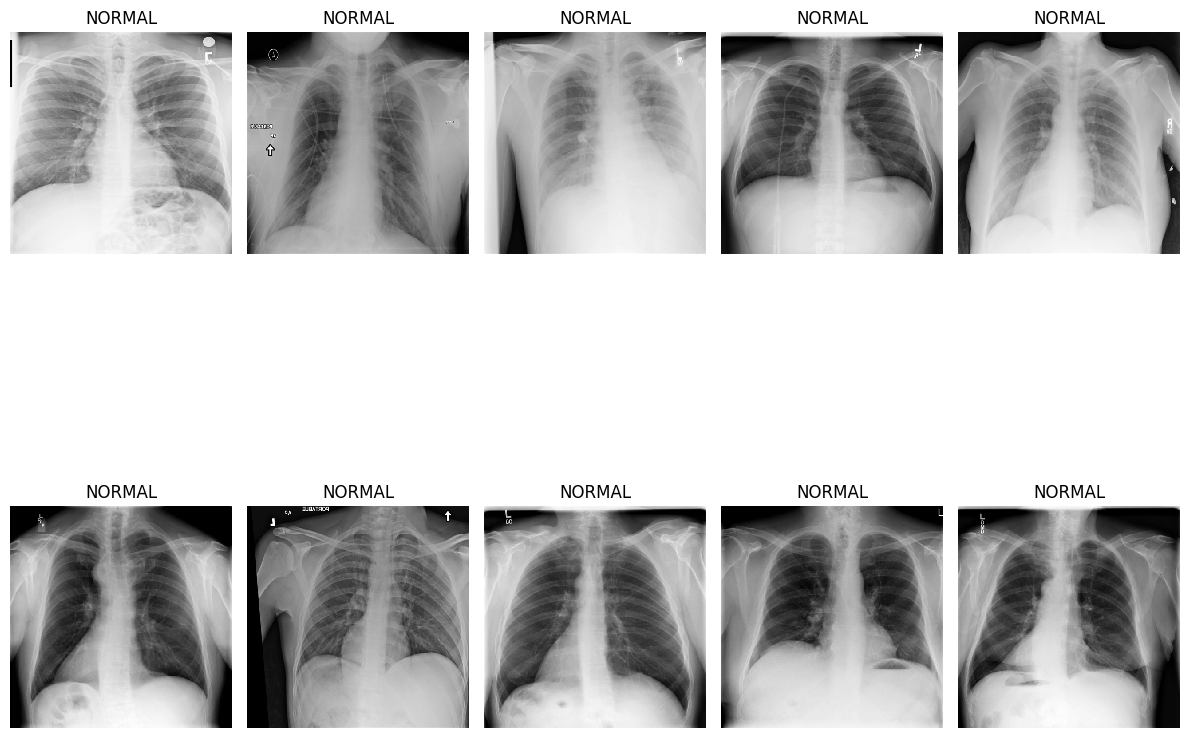

In [45]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'TUBERCULOSIS'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

# 4 Convolutional Neural Network

## 4.1 Necessary Imports

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

## 4.2 CNN Architecture

In [47]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))

c:\Users\divya\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Compile

In [48]:
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Model Summary

In [49]:
cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 498, 498, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 249, 249, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 247, 247, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 123, 123, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 121, 121, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 58, 58, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 27, 27, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     1,384,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,467,137 (5.60 MB)

 Trainable params: 1,467,137 (5.60 MB)

 Non-trainable params: 0 (0.00 B)

Visualize CNN model

In [50]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## 4.3 Fit the model

Defining callback list

In [51]:
early = EarlyStopping(monitor= "val_loss", mode= "min", patience= 3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

Assigning Class Weights

In [52]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train.classes),
    y=train.classes
)
cw = dict(zip(np.unique(train.classes), weights))
print(cw)


{np.int32(0): np.float64(0.5997959183673469), np.int32(1): np.float64(3.005112474437628)}


Training

In [53]:
cnn.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

c:\Users\divya\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 124s 665ms/step - accuracy: 0.8302 - loss: 0.4349 - val_accuracy: 0.8893 - val_loss: 0.2839 - learning_rate: 0.0010
Epoch 2/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 114s 620ms/step - accuracy: 0.9003 - loss: 0.2556 - val_accuracy: 0.9512 - val_loss: 0.1213 - learning_rate: 0.0010
Epoch 3/25
 10/184 ━━━━━━━━━━━━━━━━━━━━ 1:51 639ms/step - accuracy: 0.9609 - loss: 0.1374

KeyboardInterrupt: 

# 5 Evaluate

In [ ]:
# pd.DataFrame(cnn.history.history).plot()

In [ ]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - accuracy: 0.9762 - loss: 0.0949
The testing accuracy is : 97.62470126152039 %


In [ ]:
preds = cnn.predict(test,verbose=1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step


In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

Confussion Matrix

<Axes: >

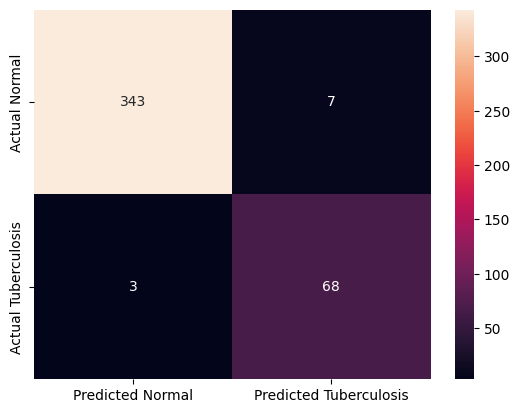

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Tuberculosis"],
columns=["Predicted Normal", "Predicted Tuberculosis"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

Classification Report

In [ ]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','TUBERCULOSIS']))

              precision    recall  f1-score   support

      NORMAL       0.99      0.98      0.99       350
TUBERCULOSIS       0.91      0.96      0.93        71

    accuracy                           0.98       421
   macro avg       0.95      0.97      0.96       421
weighted avg       0.98      0.98      0.98       421



(421, 500, 500, 1)
(421,)


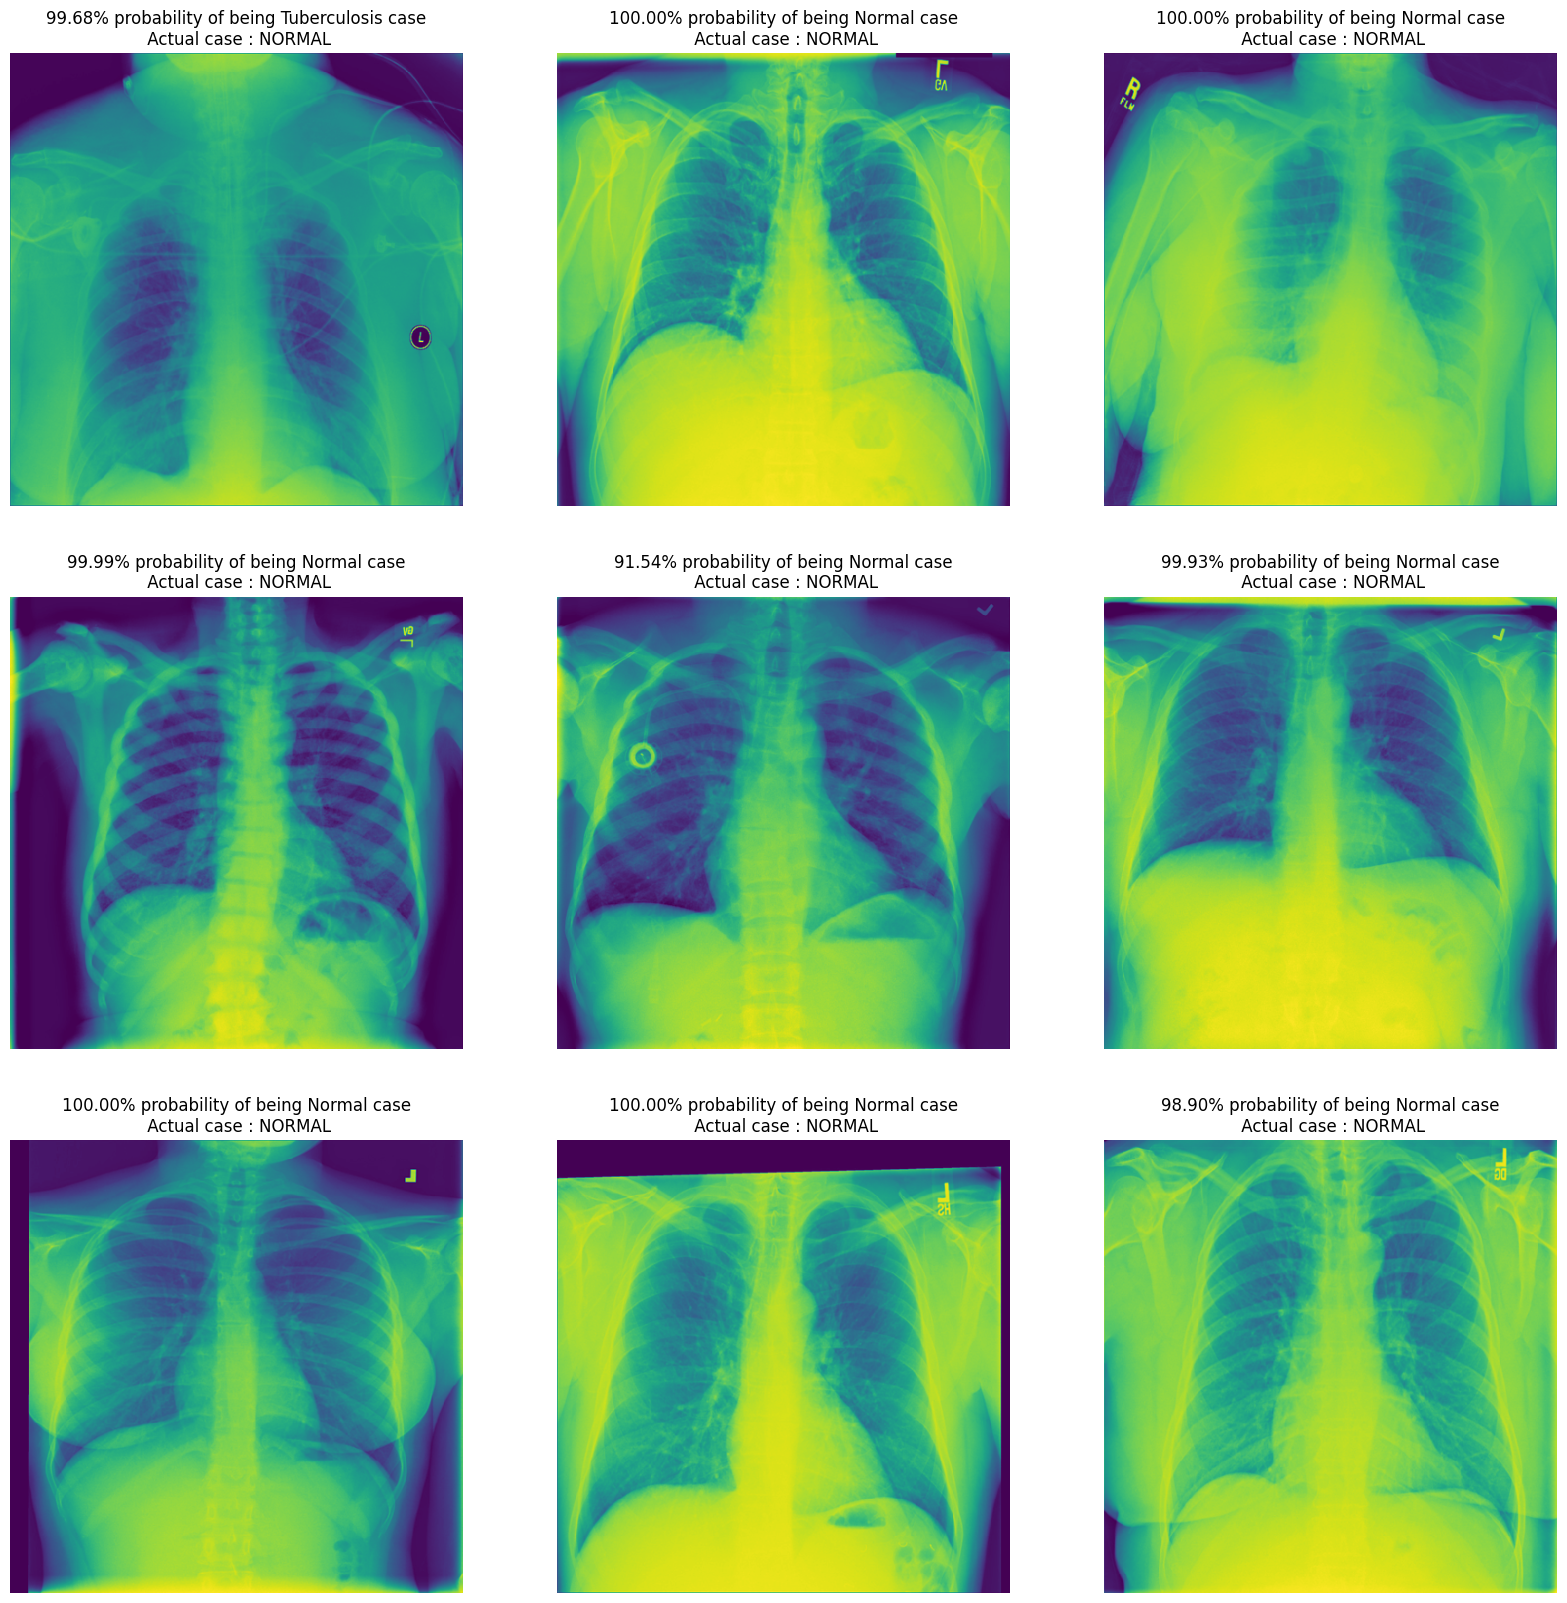

In [ ]:
test.reset()
x=np.concatenate([test.__next__()[0] for i in range(test.__len__())])
y=np.concatenate([test.__next__()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)
#this little code above extracts the images from test Data iterator without shuffling the sequence
# x contains image array and y has labels 
dic = {0:'NORMAL', 1:'TUBERCULOSIS'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5: 
    out = ('{:.2%} probability of being Tuberculosis case'.format(preds[i][0]))
      
      
  else: 
    out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
  plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()


In [56]:
from tensorflow.keras.models import load_model

model = load_model("your_model.h5")   # load from HDF5 or SavedModel
model.save("new_model.keras")         # saves in TF 2.x compatible format


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'your_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

NameError: name 'model' is not defined